In [1]:
using Random, DataFrames, Statistics, LinearAlgebra, Plots, Distributions, ShiftedArrays, StatsPlots, MLBase
using JuMP, Gurobi
using RollingFunctions

const GRB_ENV = Gurobi.Env()

Academic license - for non-commercial use only - expires 2021-07-08


Gurobi.Env(Ptr{Nothing} @0x00007fbf7c0d6200, false, 0)

In [2]:
#ENV["GUROBI_HOME"] = "/Library/gurobi910/mac64/"
#import Pkg
#Pkg.add("Gurobi")
#Pkg.build("Gurobi")

In [3]:
mu = 0
sig = 0.15

t_window = 100
axis = 1:t_window;
n_universe = 20

ret = rand(Normal(mu, sig), (t_window, n_universe))
ret = ret .- median(ret, dims=2)


size(ret)

(100, 100)

Your GR installation is incomplete. Rerunning build step for GR package.


┌ Error: Error importing GR_jll:
│   err = InitError(:PCRE_jll, InterruptException())
└ @ GR /Users/julesroche/.julia/packages/GR/Hsil0/src/funcptrs.jl:36
┌ Info: Switching provider to GR due to error in depsfile
│   depsfile = /Users/julesroche/.julia/packages/GR/Hsil0/deps/deps.jl
└ @ GR /Users/julesroche/.julia/packages/GR/Hsil0/src/GR.jl:333
┌ Info: Emptying depsfile. GR provider is GR
│   provider = GR
│   depsfile = /Users/julesroche/.julia/packages/GR/Hsil0/deps/deps.jl
└ @ GR.Builder /Users/julesroche/.julia/packages/GR/Hsil0/deps/build.jl:128
┌ Info: Downloading pre-compiled GR 0.57.2 Darwin binary
└ @ GR.Builder /Users/julesroche/.julia/packages/GR/Hsil0/deps/build.jl:193


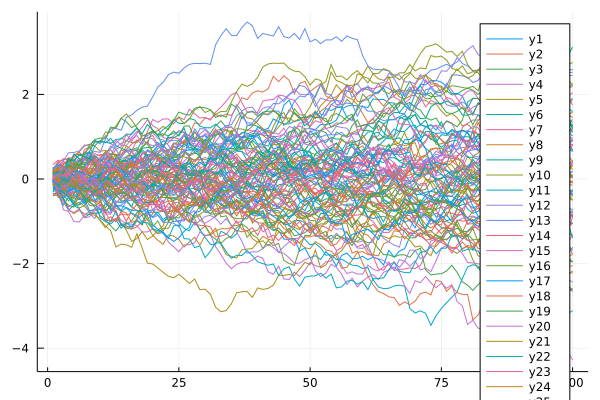

┌ Info: GR was successfully rebuilt
└ @ GR /Users/julesroche/.julia/packages/GR/Hsil0/src/GR.jl:342


In [4]:
plot(axis, cumsum(ret, dims=1))

In [168]:
#ShiftedArray(x, 1)
# lag = shift(1)
# lead = shift(-1)

acc: 0.5063

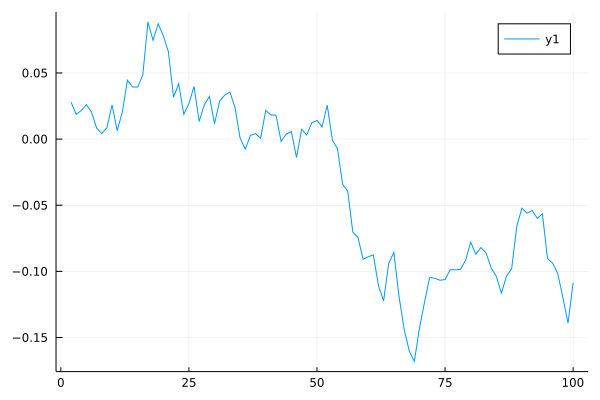

In [510]:
" random pnl "


p = 0.5
x = rand(Binomial(1,p), (t_window, n_universe))
pred = 2 .* x  .- 1
pos = pred ./ sum(abs.(pred), dims=2)
pnl = sum(lag(pos, default = NaN) .* ret, dims=2);

v_gt = vcat(Int.(sign.(ret))...)
v_pred =  vcat(Int.(sign.(pred))...)
print("acc: ", correctrate(v_gt, v_pred))

plot(axis[2:t_window], cumsum(pnl[2:t_window]))



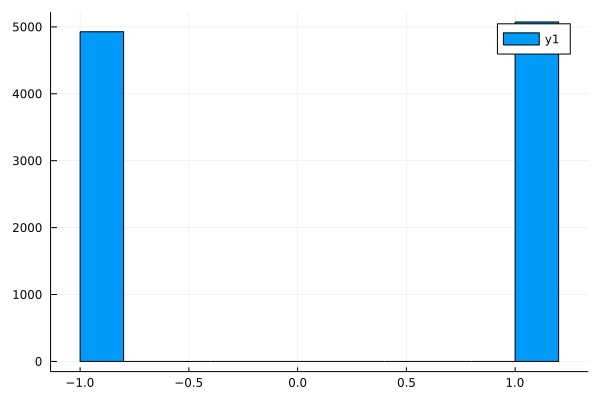

In [511]:
histogram(vcat(pred...))

acc: 0.5230303030303031
SR 4.954165935999693


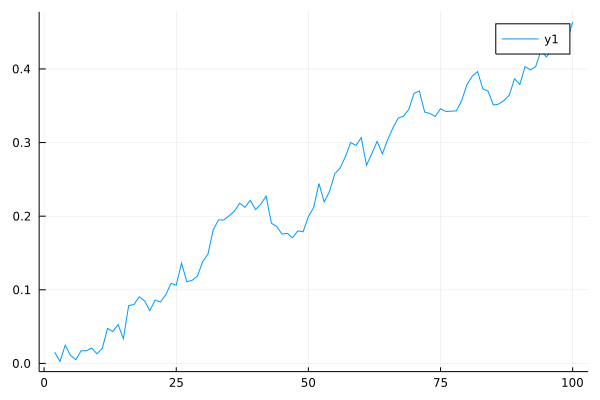

In [516]:
acc_level = 0.52

pred = sign.(lead(copy(ret))); #tomorrow's return: shift -1
ind = rand(Binomial(1, acc_level), (t_window, n_universe));
size(ind)
pred_new = copy(pred)
pred_new[ind .==0] .= -pred[ind .==0];

y_target = vcat(Int.(sign.(lead(ret)[1:end-1,:]))...) # gt of tom's returns
y_pred =  vcat(Int.(sign.(pred_new[1:end-1,:]))...);
println("acc: ", correctrate(y_target, y_pred))

pos = pred_new ./ sum(abs.(pred), dims=2)
pos = pos .- mean(pos, dims=2)
pnl_ini = sum(lag(pos, default = NaN) .* ret, dims=2);

sr = mean(pnl_ini[2:end]) / std(pnl_ini[2:end]) * 15.87
println("SR ", sr)

plot(axis[2:t_window], cumsum(pnl_ini[2:t_window]))


mean_acc: 0.5216666666666665

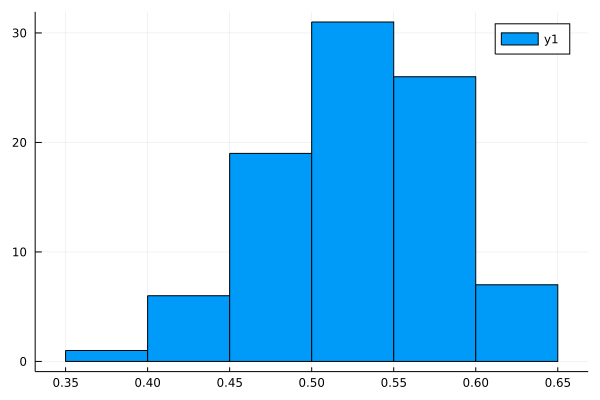

In [517]:
""" pred = tomrrow's return """

l_acc = []
for k=1:t_window -10
    pred_sign = Int.(pred_new[k,:])
    gt_sign = Int.(sign.(ret[k+1,:]))
    acc = correctrate(gt_sign, pred_sign)
    append!(l_acc, acc)
end
print("mean_acc: ", mean(l_acc))
histogram(l_acc)

In [470]:
""" adding a notion of predicted level: option 1: moving average"""

w = 10
level_mean = zeros(size(ret))
level_mean = level_mean[w:end,:]
for k=1:size(ret)[2]
    level_mean[:,k] = rollmean(abs.(ret)[:,k], w)
end

ret_pred = level_mean[1:end-1,:] .* pred_new[w:end-1,:]; # multiply the level by the sign

In [518]:
""" adding a notion of predicted level: option 1: target level => as if we could acces the gt values"""

w = 10
level_target = lead(abs.(ret))
ret_pred_target = level_target[w:end-1,:] .* pred_new[w:end-1,:];
ret_pred_target

90×100 Array{Float64,2}:
  0.0628631  -0.0558133    0.0836329   …  -0.0419066    0.156679
  0.0723448   0.088471    -0.019612        0.0372863   -0.0806479
 -0.0287314   0.120819    -0.231066       -0.101284     0.362285
 -0.0668424   0.050876     0.110908        0.132393     0.187663
  0.0309883   0.0351687    0.235014        0.0919       0.0406367
  0.218317    0.181265    -0.0793051   …   0.0187011   -0.21333
 -0.140435    0.124511     0.100462        0.00187097  -0.0284638
  0.0574941  -0.172584    -0.00870358     -0.281357     0.0736175
  0.0342465  -0.0683046   -0.103212       -0.0223626   -0.0467583
  0.0906062   0.0815122    0.0135662       0.235866    -0.337488
 -0.229714    0.0834131   -0.175165    …  -0.224752    -0.00929397
  0.034765    0.0301434    0.00893385      0.154745     0.0660477
 -0.202743   -0.11657      0.064561        0.17714     -0.0982678
  ⋮                                    ⋱               
  0.0514167  -0.179891    -0.229886       -0.00881733  -0.137388
 

In [549]:
function opt_pf(v_mu, mat_sig, dc_param)


    #alpha_min = 1 / n_universe^2
    #alpha_min = 1 / n_universe/10
    alpha_min = dc_param["level_min"]
    lambda = dc_param["lambda"]

    model = Model(Gurobi.Optimizer)
    #model = Model(() -> Gurobi.Optimizer(GRB_ENV))

    @variable(model, x[i=1:n_universe])
    @variable(model, y[i=1:n_universe])
    
    # AVOID CONCENTRATION
    @constraint(model, [i=1:n_universe], y[i] >= alpha_min)
    
    # INVEST 1 DOLLARS
    @constraint(model,[i=1:n_universe], y[i]>=x[i])
    @constraint(model,[i=1:n_universe], y[i]>=-x[i])
    @constraint(model, sum(y[i] for i=1:n_universe) == 1)
    
    # BEING DOLLAR NEUTRAL
    @constraint(model, sum(x[i] for i=1:n_universe) == 0)
    

    @objective(model, Max, v_mu'x - lambda * sum(x[i] * (mat_sig*x)[i] for i=1:n_universe))

    optimize!(model);

    a = getvalue.(x);
    return a
end


opt_pf (generic function with 2 methods)

In [563]:
dict_param = Dict()
dict_param["level_min"] = 0.01
dict_param["lambda"] = 10

mat_pos = zero(n_universe)
mat_cov = cov(ret)

t_trading = size(ret_pred)[1]
for k=1:t_trading
    #v_ret = ret_pred[k,:]
    v_ret = ret_pred_target[k,:]
    x_opt = opt_pf(v_ret, mat_cov, dict_param);
    mat_pos = vcat(mat_pos, reshape(x_opt, (1, n_universe)))
end



Academic license - for non-commercial use only - expires 2021-07-08
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 302 rows, 200 columns and 700 nonzeros
Model fingerprint: 0xa9889776
Model has 5050 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-03, 5e-01]
  QObjective range [5e-06, 6e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+00]
Presolve removed 301 rows and 100 columns
Presolve time: 0.00s
Presolved: 1 rows, 100 columns, 100 nonzeros
Presolved model has 5050 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 99
 AA' NZ     : 4.950e+03
 Factor NZ  : 5.050e+03
 Factor Ops : 3.384e+05 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -

SR: 4.844558768805655

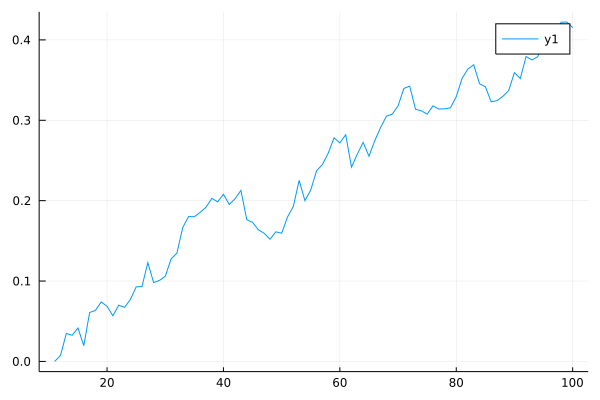

In [564]:
pnl = sum(lag(mat_pos)[2:end,:] .* ret[w:end-1,:], dims=2)
#pnl = sum(lag(mat_pos)[2:end,:] .* ret[w:end-1,:], dims=2)

sr = mean(pnl) / std(pnl) * 15.87
print("SR: ", sr)
axis_n = 11:t_window
plot(axis_n, cumsum(pnl, dims=1))

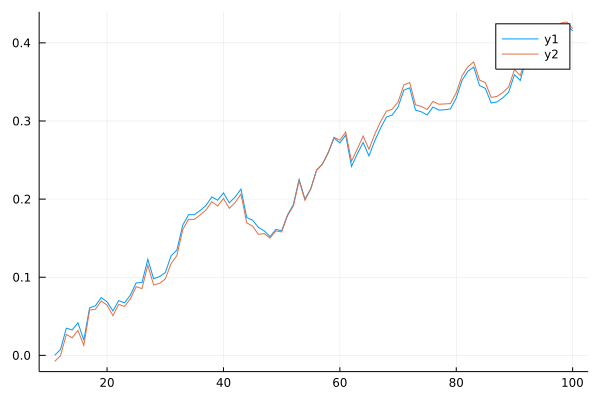

In [565]:
plot(axis_n, [cumsum(pnl, dims=1), cumsum(pnl_ini[10:end-1], dims=1)])

In [552]:
maximum(mat_pos, dims=2)

91×1 Array{Float64,2}:
 0.0
 0.2982941681971641
 0.23539439626890932
 0.24558606849962
 0.3232879289564425
 0.288603907530356
 0.3184786365668962
 0.28116397481629946
 0.19865495107550923
 0.22204895702225766
 0.1495361972861524
 0.3314390131073707
 0.22591497048265072
 ⋮
 0.36025854646255906
 0.28349872754658795
 0.13988509421879547
 0.4267865820321598
 0.24677627226965768
 0.3933471286760666
 0.2630819886838946
 0.24054266292562432
 0.17805120525271625
 0.14223640007432187
 0.24405137140772545
 0.15320100989268157

In [507]:
#mat_pos

91×50 Array{Float64,2}:
  0.0    0.0    0.0    0.0    0.0   …   0.0    0.0    0.0    0.0    0.0
  0.01  -0.01   0.01   0.01  -0.01      0.01  -0.01  -0.01  -0.01   0.01
 -0.01   0.01   0.01  -0.01   0.01     -0.01  -0.01  -0.01  -0.01   0.01
 -0.01   0.01   0.01   0.01   0.01     -0.01   0.01  -0.01   0.01   0.24
 -0.01  -0.01   0.01  -0.01  -0.01     -0.01  -0.01  -0.01  -0.01   0.01
 -0.01   0.01  -0.01  -0.01   0.01  …   0.01  -0.01   0.01  -0.01   0.01
 -0.01   0.01  -0.01  -0.01  -0.28     -0.01  -0.01  -0.01   0.01  -0.01
 -0.01   0.01  -0.01  -0.01  -0.01     -0.01  -0.01  -0.01  -0.01  -0.01
 -0.01   0.01   0.01   0.01   0.01      0.01   0.2    0.01  -0.01  -0.01
  0.01   0.01   0.01  -0.01   0.01      0.01  -0.01  -0.01  -0.01  -0.01
 -0.01   0.01   0.01   0.01  -0.01  …  -0.01  -0.01  -0.01   0.01  -0.01
 -0.01  -0.01  -0.01   0.01   0.01     -0.01   0.01  -0.01   0.01  -0.01
 -0.01  -0.01  -0.01  -0.25  -0.01      0.01  -0.01  -0.01   0.01   0.01
  ⋮                         

In [174]:
""" optimizing the level"""

lambda = 0.0
model = Model(Gurobi.Optimizer)

@variable(model, x[i=1:n_universe])
@variable(model, l[i=1:n_universe]) # level
@variable(model, y[i=1:n_universe]) # aux var

#@constraint(model, [i=1:n_universe], y[i] >= alpha_min)
@constraint(model, [i=1:n_universe], x[i] == l[i] * pred_sign[i])

@constraint(model,[i=1:n_universe], y[i]>=x[i])
@constraint(model,[i=1:n_universe], y[i]>=-x[i])

@constraint(model, sum(y[i] for i=1:n_universe) == 1)

@objective(model, Max, vec_ret'x - lambda * sum(x[i] * (mat_cov*x)[i] for i=1:n_universe))
optimize!(model)

Academic license - for non-commercial use only - expires 2021-07-08
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 61 rows, 60 columns and 140 nonzeros
Model fingerprint: 0x977ea1fb
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 4e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 61 rows and 60 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.7809590e-01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.780958968e-01

User-callback calls 32, time in user-callback 0.00 sec


In [176]:
getvalue.(l)

20-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [179]:
l = Any[]
append!(l, [[1, 2]])
append!(l, [[2, 6]])

2-element Array{Any,1}:
 [1, 2]
 [2, 6]

In [180]:
size(l)

(2,)

# Question: 
- should I agregate before / after ? 
- Shoudl I 

In [ ]:
""" Test simple Markovitz one days with a minimum level"""

vec_ret = ret_pred[17,:]
mat_cov = cov(ret);

lambda = 0.0
#alpha_min = 1 / n_universe^2
alpha_min = 0.0001

#model = Model(Gurobi.Optimizer)
model = Model(() -> Gurobi.Optimizer(GRB_ENV))

@variable(model, x[i=1:n_universe])
@variable(model, y[i=1:n_universe])

# AVOINDING BEING TOO CONCENTRATED
@constraint(model, [i=1:n_universe], y[i] >= alpha_min)

# INVEST 1 DOLLARS IN ABSOLUTE VALUE
@constraint(model,[i=1:n_universe], y[i]>=x[i])
@constraint(model,[i=1:n_universe], y[i]>=-x[i])
@constraint(model, sum(y[i] for i=1:n_universe) == 1)

# BEING DOLLAR NEUTRAL
@constraint(model, sum(x[i] for i=1:n_universe) == 0)

# MEAN-VAR PORTFOLIO
@objective(model, Max, vec_ret'x - lambda * sum(x[i] * (mat_cov*x)[i] for i=1:n_universe))

optimize!(model);

a = getvalue.(x);
a

# Remark and problems:
- with independant asset (no correlation) + no correlation between prediction => markovitz useless => provide a very concentrated asset on only 1 asset => does not expoite LLN 